In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [98]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (16,3)

#plotsize_mem_conn_subplots = (cm2inch(17),cm2inch(7))

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['NUM_VPS'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['NUM_VPS'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['NUM_VPS'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['NUM_VPS'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['NUM_VPS'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [5]:
pc=plt.rcParams['axes.prop_cycle']

In [6]:
def plot_results(df, name, plot_T_sim=True):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=['NUM_VPS'], values=values)
    df_mem = pd.pivot_table(df, index=['NUM_VPS'], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=45, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc='lower right')
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel('N_VP')
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel('N_VP')
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [7]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

In [113]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum']
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum']
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum']
    return df

In [9]:
def memory_per_connection(df):
    """We use Connection memory + ini memory """
    df['memory_per_connection'] = ((df['VSize_ini_sum']-df['VSize_nodes_sum'])/df['N_conns_sum'])*1024
    return df

In [111]:
def plot_compare(df, name, values=None):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    df_p = pd.pivot_table(df, index='NUM_VPS', columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=45)
        axes[indx].legend(fontsize=fontsize_legends, loc='lower right')

    plt.subplots_adjust(wspace=0.4)

    # y-axis labels
    axes[0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel('N_VP')

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [11]:
def plot_conn_and_mem(df, name):
    """Plot time per connection and memory per connection for different rules"""
    
    df_p = pd.pivot_table(df, index=['NUM_VPS', 'rule'], values=['time_per_connection', 'memory_per_connection'])
    
    # Make subplots
    axes = df_p.plot(kind='bar', subplots=True, legend=False, layout=(1,2),
                     x=df['NUM_VPS'].sort_values(ascending=True),
                     fontsize=6, rot=45, figsize = plotsize_mem_conn_subplots)
    
    
    color = plt.cm.Dark2(np.arange(len(df.rule.unique())))
    colors = [color[i] for i in range(len(df.rule.unique()))]*len(df)
    labels = list(df.rule.sort_values(ascending=True).unique())
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in range(len(labels))]
    
    for ax in axes.flat:
        ax.legend(handles=handles, labels=labels, fontsize=6, loc='upper right')
        for i,bar in enumerate(ax.patches):
            bar.set_color(colors[i])
    
    plt.subplots_adjust(wspace=0.25)
    
    # x-axis labels
    for ax in axes[0]:
        ax.set_xlabel('N_VP')
    
    # y-axes labels
    axes[0][0].set_ylabel('Memory [B]')
    axes[0][1].set_ylabel('Time [ns]')

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [12]:
def plot_fixed_VP_diff_threads(df, name):
    df_p = pd.pivot_table(df, index=['THREADS_PER_TASK'],
                               values=['T_conns_min', 'T_ini_min', 'T_conn', 'T_sim'])
    df_mem_p = pd.pivot_table(df, index=['THREADS_PER_TASK'], values=['connections', 'ini', 'other'])

    # Make subplots
    ncols = 5
    fig, axes = plt.subplots(nrows=1, ncols=ncols)

    df_p.plot(kind='bar', subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis, rot=45)
    df_mem_p.plot(kind='bar', stacked=True, legend=True, ax=axes[ncols-1],
                  fontsize=fontsize_axis, rot=45, color=['purple', 'pink', 'red'])
    plt.legend(fontsize=6, loc='lower right')

    plt.subplots_adjust(wspace=0.4)

    # x- and y-axes labels
    for ax in axes:
        ax.set_xlabel('Threads')

    axes[0].set_ylabel('Time [s]')
    axes[ncols-1].set_ylabel('Memory [MiB]')
    axes[ncols-1].set_title('memory_per_rank')
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))

    fig.savefig(name, bbox_inches='tight')

    df_p['connections'] = df_mem_p['connections']
    df_p['ini']         = df_mem_p['ini']
    df_p['other']       = df_mem_p['other'] 
    
    return df_p

# FIG. 1

## HPC_benchmark

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,54.30,42.19,99.81,2.743245,0.019534,0.055616
72,53.72,42.97,102.35,2.743245,0.024010,0.053295
144,54.19,44.75,105.35,2.743245,0.109460,0.053315
288,53.67,48.82,109.34,2.743245,0.114370,0.053327
576,52.43,60.34,120.57,2.743245,0.240082,0.053680
1152,52.39,79.09,139.73,2.743083,0.576400,0.054545


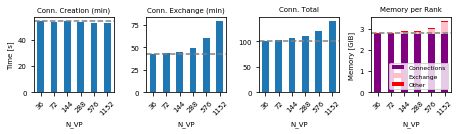

In [10]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,53.56,45.38,103.50,134.70,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,133.91,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,147.27,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,167.28,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,221.18,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,353.64,1.993083,0.460135,0.054545


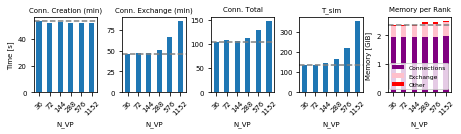

In [12]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,53.56,45.38,103.50,134.70,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,133.91,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,147.27,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,167.28,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,221.18,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,353.64,1.993083,0.460135,0.054545


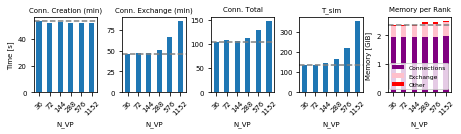

In [63]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_static_delays.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_t6_s20_p

## HPC Split into many Connect calls

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,93.72,43.75,140.69,2.743245,0.018721,0.058383
72,95.04,44.08,141.95,2.743245,0.038740,0.127677
144,97.74,45.64,149.15,2.743245,0.103275,0.231606
288,102.46,48.82,160.06,2.743245,0.104300,0.458369
576,112.52,57.72,178.35,2.743245,0.181957,0.399136
1152,133.32,77.62,219.40,2.743083,0.553613,0.257282


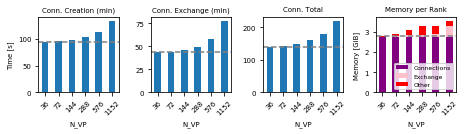

In [16]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,93.72,43.51,141.45,2.743245,0.016279,0.057569
72,231.57,43.54,289.88,2.743245,0.040368,0.125398
144,753.47,42.66,847.58,2.826579,0.019128,0.214502
288,2744.99,44.27,3124.88,2.933350,0.116690,0.336835
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


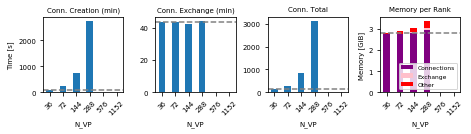

In [100]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

## HPC comparing different cases from above

Conn. Creation (min)                      Conn. Exchange (min)  \
Case                 Default Random delay   Split              Default   
NUM_VPS                                                                  
36                     54.30        53.56   93.72                42.19   
72                     53.72        51.74   95.04                42.97   
144                    54.19        52.82   97.74                44.75   
288                    53.67        52.01  102.46                48.82   
576                    52.43        52.04  112.52                60.34   
1152                   52.39        52.05  133.32                79.09   

                            Conn. Total                      Memory per Rank  \
Case    Random delay  Split     Default Random delay   Split         Default   
NUM_VPS                                                                        
36             45.38  43.75       99.81       103.50  140.69        2.818396   
72             46.95  44.08      102.35       107.41  141.95        2.820551   
144            46.63  45.64      105.35       105.05  149.15        2.906020   
288            50.14  48.82      109.34       111.17  160.06        2.910942   
576            66.64  57.72      120.57       128.82  178.35        3.037008   
1152           85.56  77.62      139.73       147.11  219.40        3.374027   

                                
Case    Random delay     Split  
NUM_VPS                         
36          2.374711  2.820349  
72          2.376948  2.909662  
144         2.378188  3.078126  
288         2.461602  3.305914  
576         2.464905  3.324338  
1152        2.507762  3.553978

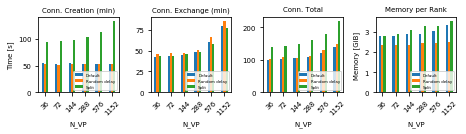

In [101]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_split_t6_s20['Case'] = ['Split'] * len(hpc_split_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_delay_t6_s20, hpc_split_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

### HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0     2498000500
1     4996000000
2     9991999000
3    19983997000
4    39967993000
5    79935985000
Name: N_conns_sum, dtype: int64
0      499500
1      999000
2     1998000
3     3996000
4     7992000
5    15984000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,55.78,49.72,110.99,457.37,2.7229,0.045869,0.067822
72,55.91,53.33,118.45,467.97,2.7229,0.317873,0.070221
144,55.52,54.99,121.10,492.21,2.7229,0.168870,0.070241
288,55.37,65.72,130.18,526.72,2.7229,0.312809,0.070252
576,54.80,96.50,161.45,590.03,2.7229,0.653931,0.070606
1152,54.48,156.48,221.62,695.97,2.7229,0.771078,0.071308


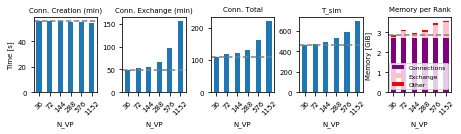

In [102]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comp_benchmark_conn_sort_update_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,44.25,39.58,86.77,1.982666,0.095207,0.062289
72,44.43,40.50,88.60,1.978109,0.139478,0.068432
144,46.16,41.46,91.95,1.978109,0.220167,0.068452
288,48.49,43.75,95.33,1.978109,0.124685,0.068463
576,53.36,54.05,110.80,1.978109,0.398448,0.068817
1152,64.57,96.74,172.28,1.978109,0.443953,0.069519


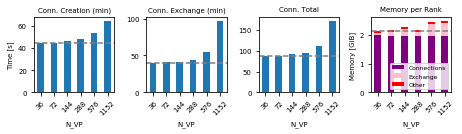

In [103]:
population = pd.read_csv('benchmark_results/population_model_conn_sort_update_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## Compare

### HPC benchmark vs HPC benchmark with many synapses per neuron

Conn. Creation (min)               Conn. Exchange (min)                \
Case                 Default many synapses              Default many synapses   
NUM_VPS                                                                         
36                     54.30         55.78                42.19         49.72   
72                     53.72         55.91                42.97         53.33   
144                    54.19         55.52                44.75         54.99   
288                    53.67         55.37                48.82         65.72   
576                    52.43         54.80                60.34         96.50   
1152                   52.39         54.48                79.09        156.48   

        Conn. Total               Memory per Rank                
Case        Default many synapses         Default many synapses  
NUM_VPS                                                          
36            99.81        110.99        2.818396      2.836591  
72           102.35        118.45        2.820551      3.110994  
144          105.35        121.10        2.906020      2.962012  
288          109.34        130.18        2.910942      3.105962  
576          120.57        161.45        3.037008      3.447438  
1152         139.73        221.62        3.374027      3.565286

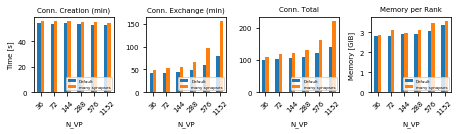

In [118]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_pop_comp['Case'] = ['many synapses'] * len(hpc_pop_comp)

hpc_cases = pd.concat([hpc_t6_s20, hpc_pop_comp])

hpc_synapse_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases.pdf')
save_table_latex(hpc_synapse_cases_p.to_latex(), 'latex_tables/hpc_synapse_cases_table.txt')

hpc_synapse_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                                Default many synapses   
NUM_VPS                                                     
36                             2.144994e-08  2.232986e-08   
72                             1.061041e-08  1.119095e-08   
144                            5.351623e-09  5.556446e-09   
288                            2.650135e-09  2.770717e-09   
576                            1.294453e-09  1.371097e-09   
1152                           6.467326e-10  6.815454e-10   

        Conn. Exchange Time per Conn. (min)                \
Case                                Default many synapses   
NUM_VPS                                                     
36                             1.666617e-08  1.990392e-08   
72                             8.487145e-09  1.067454e-08   
144                            4.419360e-09  5.503403e-09   
288                            2.410650e-09  3.288631e-09   
576                            1.489744e-09  2.414432e-09   
1152                           9.763330e-10  1.957566e-09   

        Total Conn. Time per Conn.                
Case                       Default many synapses  
NUM_VPS                                           
36                    3.942759e-08  4.443154e-08  
72                    2.021548e-08  2.370897e-08  
144                   1.040401e-08  1.211970e-08  
288                   5.399026e-09  6.514212e-09  
576                   2.976772e-09  4.039482e-09  
1152                  1.724908e-09  2.772468e-09

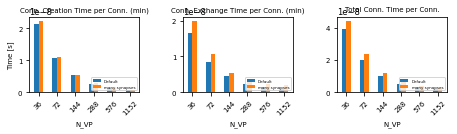

In [119]:
hpc_cases = time_per_connection(hpc_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_cases_tpc__p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases_time_per_conn.pdf', values)
save_table_latex(hpc_synapse_cases_tpc__p.to_latex(), 'latex_tables/hpc_synapse_cases_time_per_conn_table.txt')

hpc_synapse_cases_tpc__p

### HPC benchmark with many synapses per neuron vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case           many synapses population        many synapses population   
NUM_VPS                                                                   
36                     55.78      44.25                49.72      39.58   
72                     55.91      44.43                53.33      40.50   
144                    55.52      46.16                54.99      41.46   
288                    55.37      48.49                65.72      43.75   
576                    54.80      53.36                96.50      54.05   
1152                   54.48      64.57               156.48      96.74   

          Conn. Total            Memory per Rank             
Case    many synapses population   many synapses population  
NUM_VPS                                                      
36             110.99      86.77        2.836591   2.140162  
72             118.45      88.60        3.110994   2.186019  
144            121.10      91.95        2.962012   2.266728  
288            130.18      95.33        3.105962   2.171257  
576            161.45     110.80        3.447438   2.445374  
1152           221.62     172.28        3.565286   2.491581

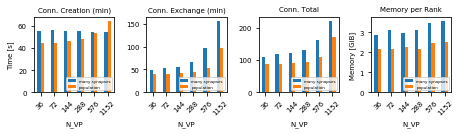

In [120]:
population['Case'] = ['population'] * len(population)

hpc_synapse_pop_cases = pd.concat([hpc_pop_comp, population])

hpc_synapse_pop_cases_p = plot_compare(hpc_synapse_pop_cases, 'benchmark_figures/hpc_synapse_vs_pop_cases.pdf')
save_table_latex(hpc_synapse_pop_cases_p.to_latex(), 'latex_tables/hpc_synapse_vs_pop_cases_table.txt')

hpc_synapse_pop_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                          many synapses    population   
NUM_VPS                                                     
36                             2.232986e-08  1.770000e-08   
72                             1.119095e-08  8.886000e-09   
144                            5.556446e-09  4.616000e-09   
288                            2.770717e-09  2.424500e-09   
576                            1.371097e-09  1.334000e-09   
1152                           6.815454e-10  8.071250e-10   

        Conn. Exchange Time per Conn. (min)                \
Case                          many synapses    population   
NUM_VPS                                                     
36                             1.990392e-08  1.583200e-08   
72                             1.067454e-08  8.100000e-09   
144                            5.503403e-09  4.146000e-09   
288                            3.288631e-09  2.187500e-09   
576                            2.414432e-09  1.351250e-09   
1152                           1.957566e-09  1.209250e-09   

        Total Conn. Time per Conn.                
Case                 many synapses    population  
NUM_VPS                                           
36                    4.443154e-08  3.470800e-08  
72                    2.370897e-08  1.772000e-08  
144                   1.211970e-08  9.195000e-09  
288                   6.514212e-09  4.766500e-09  
576                   4.039482e-09  2.770000e-09  
1152                  2.772468e-09  2.153500e-09

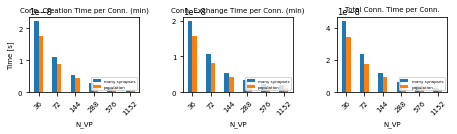

In [121]:
hpc_synapse_pop_cases = time_per_connection(hpc_synapse_pop_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_pop_tpc_cases_p = plot_compare(hpc_synapse_pop_cases,
                                           'benchmark_figures/hpc_synapse_vs_pop_cases_time_per_conn.pdf', values)
save_table_latex(hpc_synapse_pop_tpc_cases_p.to_latex(),
                 'latex_tables/hpc_synapse_vs_pop_cases_time_per_conn_table.txt')

hpc_synapse_pop_tpc_cases_p

## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,120.324007,34.458346,154.782448,1082.365881,2.551994,0.063860,-5.551115e-17
72,161.378545,42.557043,203.935915,1390.129490,2.550975,0.067006,2.189128e-02
144,245.404073,44.667060,290.071874,1664.842568,2.553382,0.171119,7.039388e-03
288,411.967277,46.147448,458.115551,2055.187021,2.626202,0.254059,-2.220446e-16
576,743.367733,36.390803,779.763724,60.539340,2.677456,0.106130,-5.551115e-17
1152,1461.262587,65.228588,1526.492920,3346.249244,2.939487,0.453178,1.665335e-16


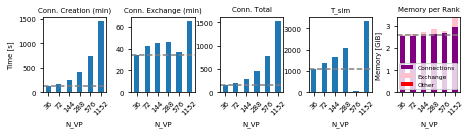

In [105]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_conn_sort_update_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')
MAM_t6_s0_0625_p

## 4x4 mesocircuit

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,N_conns_sum,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),connections,ini,other,Memory per Rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.55,169.435000,169.10,...,345443323,175.15,175.65,175.15,169.10,6.05,0.502441,0.112576,0.049678,0.664696
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,0.94,193.399167,193.27,...,690927633,199.94,200.46,199.94,193.27,6.66,0.521647,0.103027,0.063959,0.688634
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.18,227.260833,226.92,...,1381963143,234.20,234.88,234.20,226.92,7.27,0.540202,0.123834,0.075698,0.739733
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.88,330.619792,330.18,...,2763938640,338.22,339.09,338.22,330.18,8.02,0.455751,0.173929,0.103053,0.732733
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.97,519.575833,519.27,...,5527888387,529.73,530.76,529.73,519.27,10.44,0.409619,0.233214,0.171115,0.813949
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,21.36,927.114583,926.42,...,11055874121,940.37,942.03,940.37,926.42,13.87,0.410835,0.363299,0.303653,1.077786


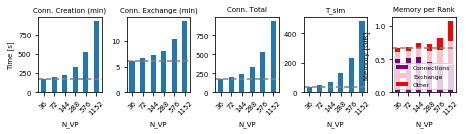

In [106]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_conn_sort_update_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=True)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')
meso_t6_s0_0625

# FIG. 2
Compare different connection rules, `SCALE = 2 * NUMBER_OF_NODES`

memory_per_connection  time_per_connection
NUM_VPS rule                                                           
36      all_to_all                       78.960075          1563.440754
        bernoulli                        55.490478          2004.783439
        indegree                         55.803430          1869.354472
        outdegree                        48.173536          6246.234038
        symmetric bernoulli             105.575844         15237.335303
72      all_to_all                       69.169954          1777.295056
        bernoulli                        48.268972          2040.705739
        indegree                         47.898334          1812.921509
        outdegree                        45.021093         12541.696013
        symmetric bernoulli             102.677910         28536.584152
144     all_to_all                       56.521220          1706.455993
        bernoulli                        44.507131          1921.634056
        indegree                         45.476254          1692.254327
        outdegree                        64.355788         18994.509350
        symmetric bernoulli              93.185486         56186.440872
288     all_to_all                       51.004836          1795.450267
        bernoulli                        48.514791          2096.196032
        indegree                         47.814349          1726.423465
        outdegree                        76.260008         29925.353490
        symmetric bernoulli             117.033586        126994.504390
576     all_to_all                       46.225952          1737.728167
        bernoulli                        54.255325          2551.201061
        indegree                         54.114560          1801.794951
        outdegree                        93.729715         54932.870231
        symmetric bernoulli             118.310969        376410.236989
1152    all_to_all                       45.980741          1782.197126
        bernoulli                        68.351317          3677.545725
        indegree                         68.358277          1946.848929
        outdegree                        95.952706        101504.467618
        symmetric bernoulli                    NaN                  NaN

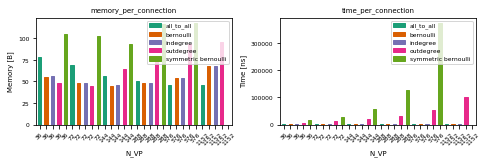

In [193]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_in.csv')
hpc_in['rule'] = ['indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_out.csv')
hpc_out['rule'] = ['outdegree']*len(hpc_out)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_bern.csv')
hpc_bern['rule'] = ['bernoulli']*len(hpc_bern)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_all.csv')
hpc_all['rule'] = ['all_to_all']*len(hpc_all)

hpc_sym = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_sym.csv')
hpc_sym['rule'] = ['symmetric bernoulli']*len(hpc_sym)

#hpc_one = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_one.csv')
#hpc_one['rule'] = ['one_to_one']*len(hpc_one)

hpc_rules = pd.concat([hpc_in, hpc_out, hpc_bern, hpc_all, hpc_sym])#, hpc_one])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)
hpc_rules = memory_per_connection(hpc_rules)

hpc_rules_p = plot_conn_and_mem(hpc_rules, 'benchmark_figures/hpc_rules_no_sym.pdf')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_table_no_sym.txt')

hpc_rules_p

# FIG. 3
Compare hpc with few neurons per node and hpc with many neurons per node

memory_per_connection  time_per_connection
NUM_VPS rule                                                    
36      few neurons               41.197881          1419.393271
        many neurons              41.840480          1599.535308
72      few neurons               41.264633          1455.514778
        many neurons              45.950896          1707.045637
144     few neurons               42.538835          1498.177792
        many neurons              43.699239          1745.236364
288     few neurons               42.612066          1554.919486
        many neurons              45.874387          1876.093156
576     few neurons               44.486655          1714.620880
        many neurons              51.029284          2326.741801
1152    few neurons               49.499309          1987.094456
        many neurons              52.799559          3193.883706

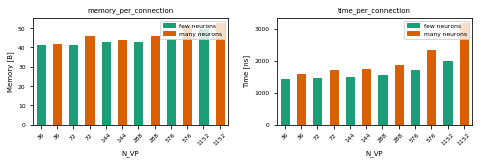

In [187]:
hpc_t6_s20['rule']  = ['few neurons']*len(hpc_t6_s20)
hpc_pop_comp['rule'] = ['many neurons']*len(hpc_pop_comp)
#population['rule'] = ['population']*len(population)

hpc_few_many = pd.concat([hpc_t6_s20, hpc_pop_comp])#, population])

hpc_few_many = time_per_connection(hpc_few_many)
hpc_few_many = memory_per_connection(hpc_few_many)

hpc_few_many_p = plot_conn_and_mem(hpc_few_many, 'benchmark_figures/hpc_few_many.pdf')
save_table_latex(hpc_few_many_p.to_latex(), 'latex_tables/hpc_few_many_table.txt')

hpc_few_many_p

# FIG. 4
Compare nblocks and population

memory_per_connection  time_per_connection
NUM_VPS rule                                                          
36      NBLOCKS                         41.365902          2009.497507
        increasing NBLOCKS              41.329337          2020.352707
        population                      31.374837          1249.488000
72      NBLOCKS                         41.665742          2027.494688
        increasing NBLOCKS              41.690118          4140.402678
        population                      31.974492          1275.840000
144     NBLOCKS                         42.632278          2130.333658
        increasing NBLOCKS              44.198319         12554.414558
        population                      33.192851          1324.080000
288     NBLOCKS                         42.647630          2286.163072
        increasing NBLOCKS              49.193584         48065.830926
        population                      31.751127          1372.752000
576     NBLOCKS                         43.810700          2547.402186
        increasing NBLOCKS                    NaN                  NaN
        population                      35.884810          1595.520000
1152    NBLOCKS                         49.374558          3133.726081
        increasing NBLOCKS                    NaN                  NaN
        population                      36.571914          2480.832000

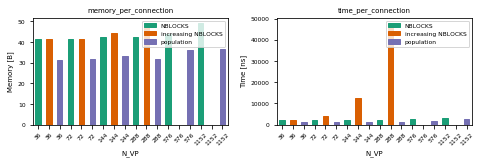

In [188]:
hpc_split_t6_s20['rule']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['rule'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['rule']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)
increasing_conns = memory_per_connection(increasing_conns)

increasing_conns_p = plot_conn_and_mem(increasing_conns, 'benchmark_figures/increasing_conns.pdf')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/increasing_conns_table.txt')

increasing_conns_p

# FIG. 5
Comapare hpc, MAM and 4x4

memory_per_connection  time_per_connection
NUM_VPS rule                                            
36      4x4               67.206764         18253.066654
        MAM               65.462663          3694.044306
        hpc               41.197881          1419.393271
72      4x4               68.258008         20835.293470
        MAM               65.515831          4867.135818
        hpc               41.264633          1455.514778
144     4x4               72.553298         24403.545182
        MAM               68.181462          6922.852204
        hpc               42.538835          1498.177792
288     4x4               68.799307         35242.229545
        MAM               72.079389         10933.376783
        hpc               42.612066          1554.919486
576     4x4               70.236281         55197.293910
        MAM               69.660058         18609.822367
        hpc               44.486655          1714.620880
1152    4x4               84.581458         97984.675670
        MAM               84.902402         36431.240093
        hpc               49.499309          1987.094456

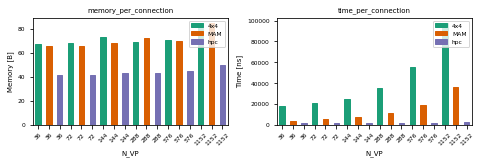

In [195]:
hpc_t6_s20['rule']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['rule']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['rule'] = ['4x4']*len(meso_t6_s0_0625)

hpc_MAM_4x4 = pd.concat([hpc_t6_s20, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_MAM_4x4 = time_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4 = memory_per_connection(hpc_MAM_4x4)
hpc_MAM_4x4_p = plot_conn_and_mem(hpc_MAM_4x4, 'benchmark_figures/hpc_MAM_4x4.pdf')
save_table_latex(hpc_MAM_4x4_p.to_latex(), 'latex_tables/hpc_MAM_4x4_table.txt')

hpc_MAM_4x4_p

# FIG. 6
Fixed VP, different threads. For `hpc_threads_n36` we have `SCALE=10*NUMBER_OF_NODES=360`.

,T_conn,T_conns_min,T_ini_min,T_sim,connections,ini,other
THREADS_PER_TASK,,,,,,,
1,26.99,11.09,13.37,133.34,1339.843750,1397.560835,417.270257
3,51.96,19.46,22.94,108.58,1362.304688,403.526545,93.997181
6,67.38,27.54,34.62,109.77,1362.386068,328.461356,49.510959
9,82.76,29.10,50.54,120.26,1362.196181,303.343867,39.169447
18,173.98,37.67,132.62,124.37,1377.522786,265.482549,28.365094
36,439.20,55.24,381.62,162.58,1372.273763,280.912423,22.012399


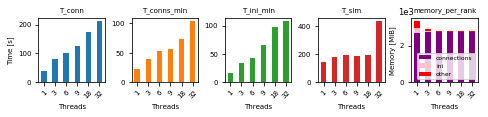

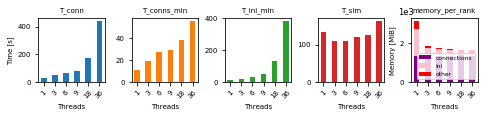

In [190]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s20_threads.csv')
hpc_threads_n36 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s10_threads_n36.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)
hpc_threads_n36 = calculate_T_conn_and_memory(hpc_threads_n36)

hpc_threads_n1_p = plot_fixed_VP_diff_threads(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf')
hpc_threads_n36_p = plot_fixed_VP_diff_threads(hpc_threads_n36, 'benchmark_figures/hpc_fixedVP_diff_threads_n36.pdf')

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
save_table_latex(hpc_threads_n36_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n36_table.txt')
#hpc_threads_n1_p
hpc_threads_n36_p